### Initilise gym enviroment 

In [1]:
import gym
import numpy as np
import random

env = gym.make('gym_connect4:connect4-v0')

num_actions = env.action_space.n
state_size = env.observation_space.n
num_actions, state_size

(7, 42)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Define Hyper-parameters

In [3]:
gamma = 0.95    # discount rate
epsilon = 1.0   # exploration rate
epsilon_min = 0.001
epsilon_decay = 0.9995
learning_rate = 0.01

### Create Network

    Input:  state observation
    
    Output: policy distribution
            value prediction

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
    
model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

### Create Experience Replay

In [5]:
from collections import namedtuple
Transition = namedtuple('Transition', 'state action n_state reward done')

# model = DQN()
if torch.cuda.is_available():
    model = model.cuda()
    
dev = 0

optimizer = optim.Adam(model.parameters())

In [6]:
state = env.reset()
state = torch.FloatTensor(state).cuda()
model(state).max()

tensor(0.1041, device='cuda:0', grad_fn=<MaxBackward1>)

### Train the agent

In [7]:
batch_size = 750
num_episodes = 50000

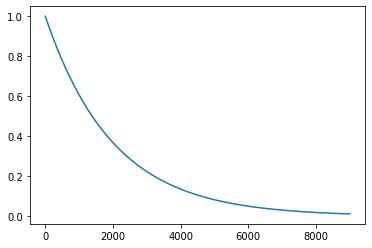

In [8]:
def decay():
    global epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        
    return epsilon
        
plt.plot([decay() for t in range(9000)])
epsilon = 1

In [9]:
def act(state):
    # Decay exploration rate
    decay()
    
    # Convert state represenation into tensor
    state = torch.tensor(state, dtype=torch.float, device=dev)
    
    # 𝜺-greedy exploration
    if np.random.rand() <= epsilon:
        return np.random.choice(num_actions)
    
    return model(state).argmax().item()

In [10]:
def train(batch):
    states = torch.tensor([x.state for x in batch], dtype=torch.float, device=dev)
    actions = torch.as_tensor([x.action for x in batch], dtype=torch.long, device=dev)
    rewards = torch.as_tensor([x.reward for x in batch], dtype=torch.float, device=dev)
    next_states = torch.as_tensor([x.n_state for x in batch], dtype=torch.float, device=dev)
    done = torch.as_tensor([x.done for x in batch], device=dev)

    q_values      = model(states)
    next_q_values = model(next_states)

    q_value          = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = rewards + gamma * next_q_value * ~done
    
    loss_fn = nn.MSELoss()
    loss = loss_fn(q_value, expected_q_value)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [11]:
memory = []
memory.clear()
loss = []

for episode in range(num_episodes):
    state = env.reset()
    
    for t in range(10000):
        # Choose an action
        action = act(state)
        new_state, reward, done, info = env.step(action)
        
        memory.append(Transition(state, action, new_state, reward, done))
        
        state = new_state
        
        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            l = train(batch)
            loss.append(l)
            print("training batch... got loss ", l)
            memory.clear()
            
        if done:
#             print("Episode finished after {} timesteps. Player {} wins".format(t+1, env.game.winner))
#             env.game.show()
            break
    
env.close()
plt.plot(loss)

AttributeError: 'Connect4' object has no attribute 'possible_moves'

### Test

In [12]:
# Take only greedy actions
epsilon = 0

start, done = env.reset(), False

while not done:
    action = act(state)
    state, reward, done, info = env.step(action)
    env.game.show()
    print(reward)

AttributeError: 'Connect4' object has no attribute 'possible_moves'

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.99995
        self.learning_rate = 0.01
        
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss = nn.MSELoss()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        return nn.Sequential(
                nn.Linear(self.state_size, 32),
                nn.ReLU(),
                nn.Linear(32, 52),
                nn.ReLU(),
                nn.Linear(52, 32),
                nn.ReLU(),
                nn.Linear(32, self.action_size))

    def act(self, state):
        self.decay()
        # Explore
        print(self.epsilon)
        if np.random.rand() <= self.epsilon:
            return np.random.choice(action_space_size)
            
        # Greedy
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return act_values.argmax().item()
    
    def decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def train(self, state, new_state, action, reward):
        state = torch.FloatTensor(state)
        reward = torch.tensor([])
        print(reward, type(reward))
        
        q_value = self.model(state)[action]
        
        loss = self.loss(q_value, reward)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        print(loss.item(), q_value, reward)

In [4]:
x = [1, 1, 1, 0, 2, 4, 2, 2]
from itertools import groupby
for k, g in groupby(x):
    print(k, g)

1 <itertools._grouper object at 0x7f30d470fa90>
0 <itertools._grouper object at 0x7f30e46bd710>
2 <itertools._grouper object at 0x7f30e46bdb90>
4 <itertools._grouper object at 0x7f30d4705a10>
2 <itertools._grouper object at 0x7f30d4705650>


In [19]:
x = {1:[1,2, 4], 2:[5,6 ,6], 3:[4]}
[v for col in x.values() for v in col]

[1, 2, 4, 5, 6, 6, 4]

In [118]:
class connect4:
    def __init__(self):
        self.board = {1: [0]*6,
                      2: [0]*6,
                      3: [0]*6,
                      4: [0]*6,
                      5: [0]*6,
                      6: [0]*6,
                      7: [0]*6}
        self.possible_moves = [i for i in range(1, 8)]
        self.player = 0
        self.winner = None
        
    def make_move(self, move):
        if move not in self.possible_moves:
            raise ValueError("move is not possible")
            
        # Switch the player and play their move in the top of the specified column
        self.player = 1 if self.player != 1 else 2
        top_of_col = self.board[move].index(0)
        self.board[move][top_of_col] = self.player
        
        # Players have reached the top of column so remove it from possible actions
        if top_of_col >= 5:
            self.possible_moves.remove(move)
            
        if self.check_winner(move, top_of_col):
            self.winner = self.player
            
    def check_winner(self, col, row):
        # just to keep variable names short
        val = self.player
        brd = self.board

        # check right 
        if col <= 4:
            # Horizontal
            if brd[col+1][row] == brd[col+2][row] == brd[col+3][row] == val:
                return True
            # Diagonal Down
            if row >= 3 and brd[col+1][row-1] == brd[col+2][row-2] == brd[col+3][row-3] == val:
                return True
            # Diagonal Up
            if row <= 2 and brd[col+1][row+1] == brd[col+2][row+2] == brd[col+3][row+3] == val:
                return True
        
        # check left
        if col >= 4:
            # Horizontal
            if brd[col-1][row] == brd[col-2][row] == brd[col-3][row] == val:
                return True
            # Diagonal Down
            if row >= 3 and brd[col-1][row-1] == brd[col-2][row-2] == brd[col-3][row-3] == val:
                return True
            # Diagonal Up
            if row <= 2 and brd[col-1][row+1] == brd[col-2][row+2] == brd[col-3][row+3] == val:
                return True
            
        # check vertical
        return any(1 for key, group in groupby(brd[col]) if len(list(group)) > 3 and key == val)

In [146]:
game = connect4()
print(game.winner)
game.make_move(2)
print(game.winner)
game.make_move(2)
print(game.winner)
game.make_move(2)
print(game.winner)
game.make_move(2)
game.make_move(2)
game.make_move(2)
print(game.winner)
game.make_move(3)
game.make_move(7)
game.make_move(4)
game.make_move(7)
game.make_move(5)

for x in range(5, -1, -1):
    print([game.board[k][x] for k in game.board])

None
None
None
None
None
[0, 2, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0]
[0, 2, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0]
[0, 2, 0, 0, 0, 0, 2]
[0, 1, 1, 1, 1, 0, 2]


In [126]:
class TicTacToe:
    """
    Board is indexed:
        [0, 1, 2,
         3, 4, 5,
         6, 7, 8]
         
         and contains either 0 or the player number (1 or 2)
         
    player represents the player who last moved
    """
    
    def __init__(self):
        self.board = [0 for i in range(9)]
        self.possible_moves = [i for i in range(9)]
        self.player = 0
    
    def make_move(self, move):
        assert move in self.possible_moves
        
        self.player = 1 if self.player != 1 else 2
        self.board[move] = self.player
        self.possible_moves.remove(move)
        
    def winner(self):
        if all(self.board):
            return 0
        
        lines = ((0,1,2),
                 (3,4,5),
                 (6,7,8),
                 (0,3,6),
                 (1,4,7),
                 (2,5,8),
                 (0,4,8),
                 (2,4,6))
        
        for i, j, k in lines:
            player = self.board[i]
            if player and player == self.board[j] == self.board[k]:
                return player
            
        return -1
    
    def render(self):
        print(self.board[:3])
        print(self.board[3:6])
        print(self.board[6:9])

In [127]:
x = TicTacToe()

In [16]:
while x.winner() is -1:
    x.render()
    x.make_move(int(input("Enter a move: ")))
    
print("\n\nand the winner is: {}".format(x.winner()))

NameError: name 'x' is not defined